In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%%shell

git clone https://github.com/GrzegorzKazana/artificial-music.git

In [12]:
!ls drive

'My Drive'


## importing dataset, splitting tracks

In [19]:
import os
import sys
import numpy as np

proj_base_path = '/content/artificial-music'
data_base_path = '/content/drive/My Drive/artificial-music/datasets'
models_base_path = '/content/drive/My Drive/artificial-music/pretrained_models'
sys.path.append(proj_base_path)

dataset_path = 'numpy/pokemon100ms_no_vel_transposed/meta/'
dataset_file = '_dicted_dataset_ignore_ratio=0.05.npy'
word_vectors_file = '_word_vectors_1000_ignore_ratio=0.05.wv'

track_path = os.path.join(data_base_path, dataset_path, dataset_file)
word_vectors_path = os.path.join(data_base_path, dataset_path, word_vectors_file)

track = np.load(track_path)

track

array(['D#3,C4', 'D#3,C4', 'D#3,C4', ..., '<UNKNOWN>', '<UNKNOWN>',
       '<TRACK_END>'], dtype='<U27')

In [20]:
from src.data_processing.embedding_sparse_notes.common import TRACK_END, UNKNOWN_FRAME

track_split_points = np.where(track == TRACK_END)[0]

# + 1, so split happens after <TRACK_END>, [:-1] to skip last, empty partition
tracks = [t.tolist() for t in np.split(track, track_split_points + 1)][:-1]
# tracks is now a list of lists of frames

['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/artificial-music', '/artificial-music', '/artificial-music', '/content/artificial-music']


## loading embedding + encoding dataset

In [21]:
from gensim.models import KeyedVectors

wv = KeyedVectors.load(word_vectors_path, mmap='r')

def vectorize_frame(frame):
    return wv[frame] if frame in wv else wv[UNKNOWN_FRAME]

vectorized_tracks = [np.array([vectorize_frame(f) for f in t]) for t in tracks]
for v in vectorized_tracks: print(v.shape, end=', ')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(2197, 16), (2197, 16), (1920, 16), (361, 16), (552, 16), (1008, 16), (533, 16), (552, 16), (552, 16), (533, 16), (1008, 16), (361, 16), (2197, 16), (2197, 16), (2197, 16), (361, 16), (1920, 16), (552, 16), (1008, 16), (552, 16), (717, 16), (717, 16), (552, 16), (1008, 16), (552, 16), (1920, 16), (361, 16), (2197, 16), (2197, 16), (1920, 16), (552, 16), (1622, 16), (717, 16), (386, 16), (1008, 16), (1622, 16), (552, 16), (552, 16), (1622, 16), (1008, 16), (386, 16), (717, 16), (552, 16), (1622, 16), (1920, 16), (361, 16), (2197, 16), (2197, 16), (1920, 16), (361, 16), (552, 16), (717, 16), (1008, 16), (386, 16), (552, 16), (1008, 16), (1008, 16), (552, 16), (386, 16), (1008, 16), (1622, 16), (552, 16), (361, 16), (1920, 16), (2197, 16), (717, 16), (361, 16), (2197, 16), (1008, 16), (533, 16), (533, 16), (386, 16), (386, 16), (533, 16), (533, 16), (361, 16), (2197, 16), (1008, 16), (361, 16), (717, 16), (717, 16), (1622, 16), (2197, 16), (1920, 16), (533, 16), (361, 16), (533, 16), (533

In [22]:
def dataset_gen(tracks, window_size, batch_size):
    """
    tracks - list of np.arrays of shape (track_length, frame_size)
    window_size - length of generated batch
    batch_size - number of sequences in batch
    """
    while True:
        # select #batch_size tracks
        selected_track_indicies = [np.random.randint(0, len(tracks)) for _ in range(batch_size)]
        # select sequence starting point for each track
        sequence_indicies = [np.random.randint(0, len(tracks[sti]) - window_size - 2)
                             for sti in selected_track_indicies]
        
        
        # create slices for x and y
        x_slice = lambda seqi: np.s_[seqi:seqi + window_size]
        y_slice = lambda seqi: np.s_[seqi + 1:seqi + window_size + 1]
        
        x = [tracks[sti][x_slice(seqi)] for sti, seqi in zip(selected_track_indicies, sequence_indicies)]
        y = [tracks[sti][y_slice(seqi)] for sti, seqi in zip(selected_track_indicies, sequence_indicies)]

        yield np.stack(x), np.stack(y)
        
x, y = next(dataset_gen(vectorized_tracks, 50, 5))
x.shape, y.shape

((5, 50, 16), (5, 50, 16))

## Setting up model

In [0]:
from tensorflow import keras as K

INPUT_SIZE = 16
HIDDEN_SIZE = 128
OUTPUT_SIZE = INPUT_SIZE

BATCH_SIZE = 16
WINDOW_SIZE = 100

INPUT_SHAPE = (None, INPUT_SIZE)
# None allows for variable seq_length between batches

#### load existing model

In [0]:
# or load saved model
model_path = 'heck_512_all/m1559929134.h5'
model = K.models.load_model(os.path.join(models_base_path, model_path))

#### or create new one

In [24]:
model = K.models.Sequential([
    K.layers.LSTM(
        HIDDEN_SIZE,
        input_shape=INPUT_SHAPE,
        return_sequences=True,
    ),
    K.layers.Dense(
        OUTPUT_SIZE,
    ),
])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
model.compile(
    loss='mean_squared_error',
    optimizer=K.optimizers.Adam(), 
    metrics=["mean_squared_error"],
)

#### define training callbacks

In [26]:
from src.training.common.training_callbacks import ModelAndLogSavingCallback, GeneratingAndPlottingCallback

# logging callback
logging_path = 'lstm'
experiment_name = f'embedded_{INPUT_SIZE}_{HIDDEN_SIZE}'
experiment_path = os.path.join(models_base_path, logging_path, experiment_name)
os.makedirs(experiment_path, exist_ok=True)
print(f'saving checkpoints and logs to {experiment_path}')

# logging disabled for now
log_callback = ModelAndLogSavingCallback(model, experiment_path)

# generating callback
from src.generating.generating import recurrent_generate
from src.generating.embedded_generating_seeds import seed_generators
from src.data_processing.common.helpers import pipe
from src.data_processing.embedding_sparse_notes.reverse_transform import np2sparse

SEED_LENGTH = 20
GENERATED_SEQ_LENGTH = 400
METHOD = 'random_noise_seed'

seed_generator = lambda: seed_generators[METHOD](
    SEED_LENGTH, INPUT_SIZE, BATCH_SIZE)

sample_generator = lambda model, seed: recurrent_generate(
    model, seed, GENERATED_SEQ_LENGTH, WINDOW_SIZE, is_binary=False)

sparse_sample_generator = lambda model, seed: pipe(
    sample_generator(model, seed),
    lambda batch_of_samples: [np2sparse(sample, wv)[0] for sample in batch_of_samples]
)

print(f'generating sequences of {GENERATED_SEQ_LENGTH} using {METHOD}')

gen_callback = GeneratingAndPlottingCallback(model, sparse_sample_generator, seed_generator)

saving checkpoints and logs to /content/drive/My Drive/artificial-music/pretrained_models/lstm/embedded_16_128
generating sequences of 400 using random_noise_seed


#### training

In [0]:
# pre training code
from time import time
epochs_elapsed = 0
minutes_elapsed = 0

data_gen = dataset_gen(vectorized_tracks, WINDOW_SIZE, BATCH_SIZE)
test_gen = dataset_gen(vectorized_tracks, WINDOW_SIZE, BATCH_SIZE)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
 99/100 [============================>.] - ETA: 0s - loss: 12.8338 - mean_squared_error: 12.8338

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


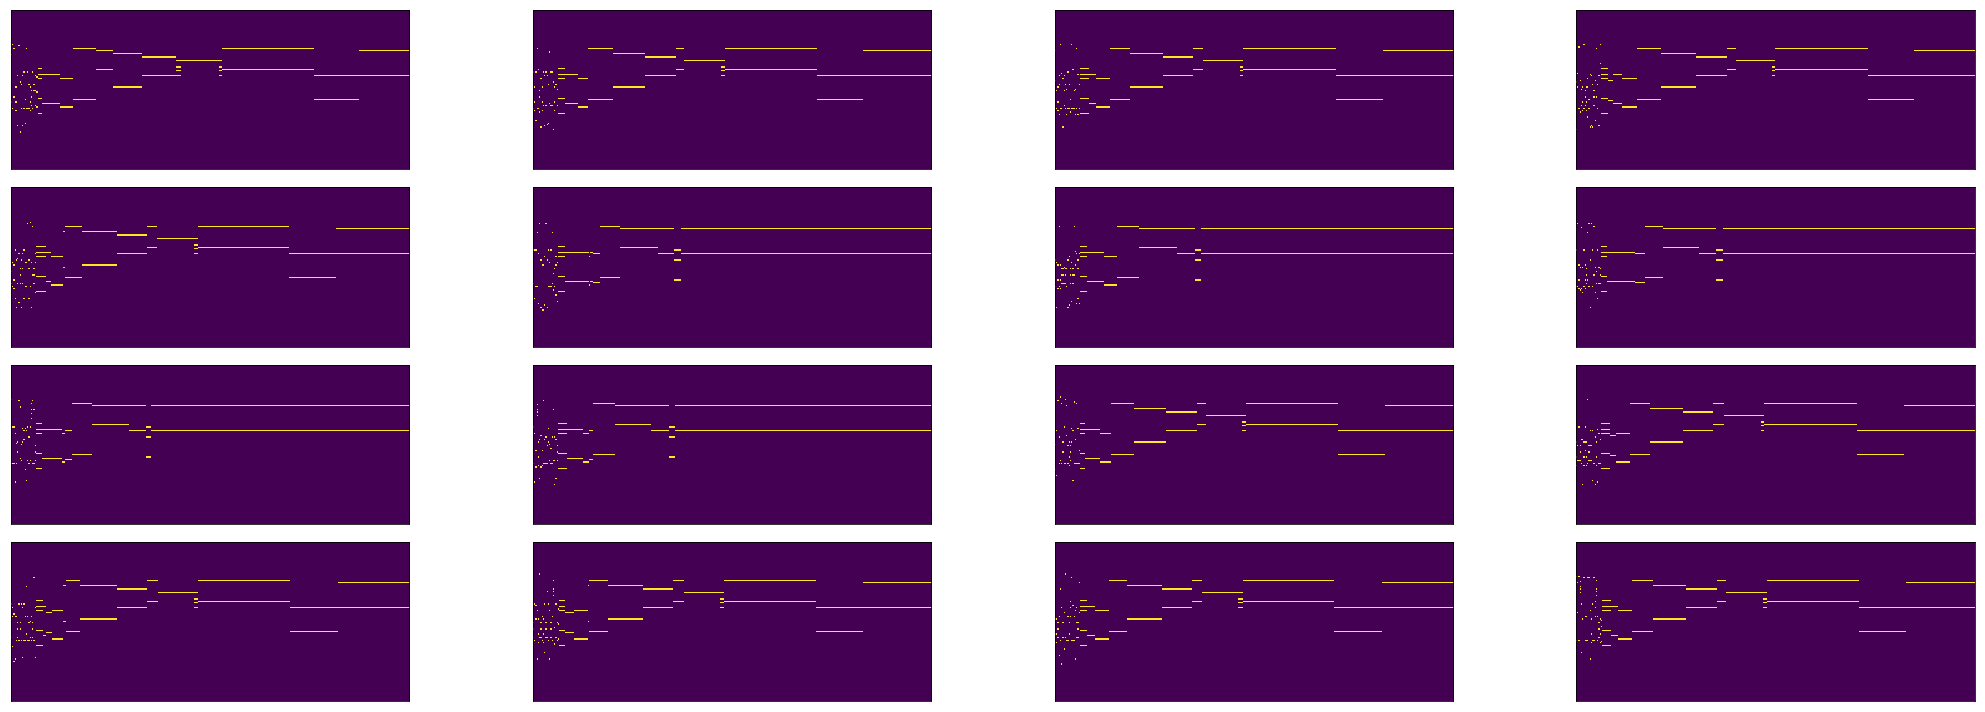

100/100 [==============================] - 26s 261ms/step - loss: 12.7997 - mean_squared_error: 12.7997 - val_loss: 9.6423 - val_mean_squared_error: 9.6423


In [28]:
EPOCHS = 1
STEPS_PER_EPOCH = 100
TEST_STEPS = 1

start_time = time()
model.fit_generator(
    data_gen,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=test_gen,
    validation_steps=TEST_STEPS,
    callbacks=[log_callback, gen_callback]
)

minutes_elapsed += (time() - start_time) // 60
epochs_elapsed += EPOCHS